# Projections

To run this jupyter notebook it is necessary to install [ProjectionExamples](https://github.com/VaclavMacha/ProjectionsExamples) julia package. This can be done using the following commands
```julia
julia> using Pkg
julia> Pkg.add(PackageSpec(url = "https://github.com/VaclavMacha/ProjectionsExamples.git", rev = "master"))
```
or using the package manager interface  (use `]` to enter package manager)
```julia
(v1.0) pkg> add https://github.com/VaclavMacha/ProjectionsExamples.git rev = "master"
```

##  Utilities

In [1]:
using ProjectionsExamples
using ProjectionsExamples.Projections, ProjectionsExamples.Distributions, ProjectionsExamples.Random

Random.seed!(666);
sd   = 12;
atol = 1e-8;

## 1. Problem (6)

$$
\begin{aligned}
\operatorname*{minimize}_{\pmb{p}}\ & \pmb{c}^\top \pmb{p} \\
\operatorname{subject\ to}\ &\sum_{i=1}^np_i=1,\\
&0\le p_i,\quad\forall i=1,\dots,n,\\
&\| \pmb{p} - \pmb{p}^0\|_{k}  \le\varepsilon.
\end{aligned}
$$

### 1.1. Comparison with a solver

Since the objective function of the problem above does not depend on the order of the components of $\pmb p$, without loss of generality we can assume that the vector $\pmb c$ is sorted. As a result of the fact that $\pmb p$ is a probability distribution, an increase in some components of $\pmb p$ has to lead to a decrease of some other components of $\pmb p$ by the same margin.To minimize the objective function, one has to decrease components of $\pmb p$ corresponding to the components of $\pmb c$ with high values, i.e. components with large index since the vector $\pmb c$ is sorted. To demonstrate this behavior, we set $\pmb{p}^{0}$ as uniform distribution and vector $\pmb c$ is generated from a normal distribution and then sorted.

In [2]:
n  = 20;
p0 = ones(n)/n;
c  = sort(rand(Normal(0,1), n));
ε  = 0.05;

p_l1_solver = Projections.minimize_linear_on_simplex_exact(p0, c, ε, 1);

p_l1   = Projections.minimize_linear_on_simplex_l1(p0, c, ε);
p_l2   = Projections.minimize_linear_on_simplex_l2(p0, c, ε);
p_lInf = Projections.minimize_linear_on_simplex_lInf(p0, c, ε);

To check if the `p_l1` solution given by our algorithm is correct, we compare it with the `p_l1_solver` solution given by the  [ECOS](https://github.com/JuliaOpt/ECOS.jl)  solver. To keep the presentation simple, we compare results only for the $l_{1}$ norm. Below show the norm of the differences between these two solutions, their values of the objective function
$$
L(\pmb{p}) = \pmb{c}^\top \pmb{p} 
$$
and their values of constraints

In [3]:
ProjectionsExamples.l1_comparison(p_l1, p_l1_solver, c, p0, ε, sd)

‖p_l1_solver - p_l1‖  = 2.6433725696000003e-12

L(p_l1_solver) = -0.198180302311
L(p_l1)        = -0.198180302304

Solver solution: 
  ⋅ ∑p = 1:       1.0 = 1
  ⋅ ‖p - p0‖ ≦ ε: 0.0500000000051 ≦ 0.05
Our solution: 
  ⋅ ∑p = 1:       1.0 = 1
  ⋅ ‖p - p0‖ ≦ ε: 0.05 ≦ 0.05


It is clear that our solution is almost identical to the solution given by the solver. The following figures show the comparison of the original uniform distribution $\pmb p^{0}$ with distributions given by the projection for $l_{1}$, $l_{2}$ and $l_{\infty}$ norm.  

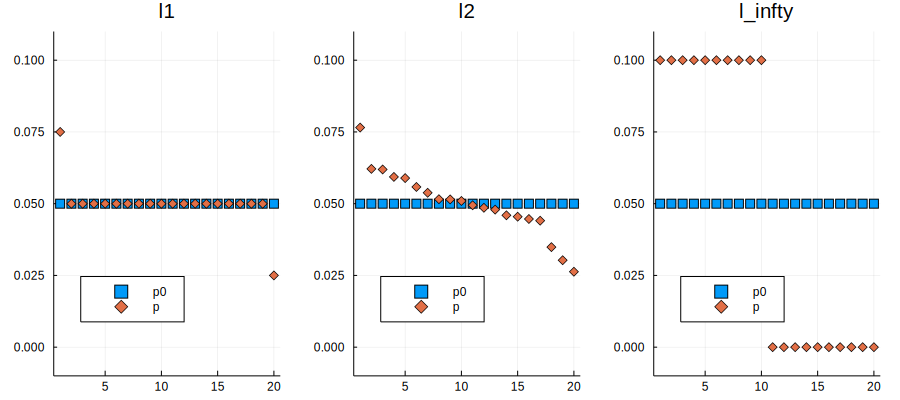

In [4]:
ProjectionsExamples.l12Inf_plots(p_l1, p_l2, p_lInf, p0, n)

### 1.2. Time comparison

In this section, we provide a simple comparison of the time complexity of the presented algorithms. The main results are presented in the figure below, where we compare the time complexity of the algorithms for the increasing length of the vector $\pmb p^{0}$. The following settings of inputs and parameters were used for the experiments

- $\pmb p^{0} \sim \mathit{Uniform}(0,1)$,
- $\pmb c \sim \mathit{Normal}(0,1)$,
- $n \in [10^{2},10^{5}]$,
- $\varepsilon = 0.1$,

where $n$ is the length of the vector $\pmb p^{0}$. For each $n$ we ran each algorithm ten times and averaged execution times. Since the algorithm for the $l_{2}$ norm uses root finding method, we show three different methods for finding root in the time comparison.  The `bisection` and `secant` methods are general methods implemented in [Roots](https://github.com/JuliaMath/Roots.jl) package. The `newton` method is a simple implementation of the [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method for our special case.

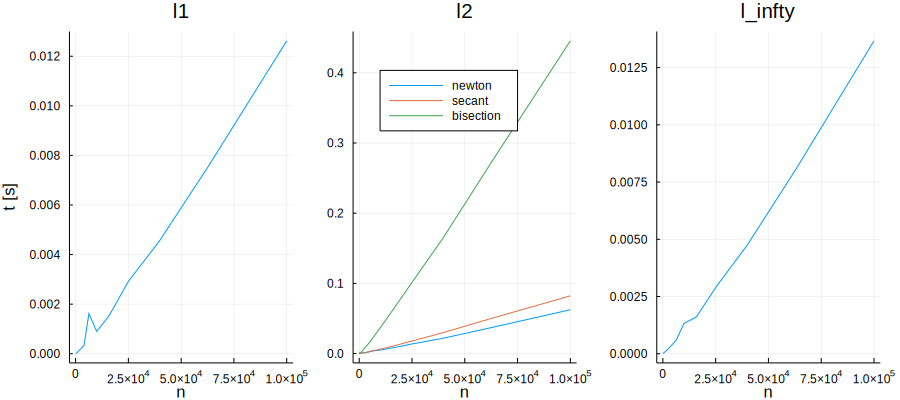

In [5]:
l = 2:0.2:5;
n = ceil.(Int64, 10 .^l);

ProjectionsExamples.l12Inf_timecomparison(n, maxreps = 10)

In the figure above we see (almost) linear dependence of time on the data size $n$. For the $l_{2}$ norm we provide the comparison of our method and the algorithm introduced in [[Philpott 2018]](https://link.springer.com/article/10.1007/s10287-018-0314-0) (denoted as `phillpot`), see figure below. Note that the computational complexity of `phillpot` algorithm is quadratic. 

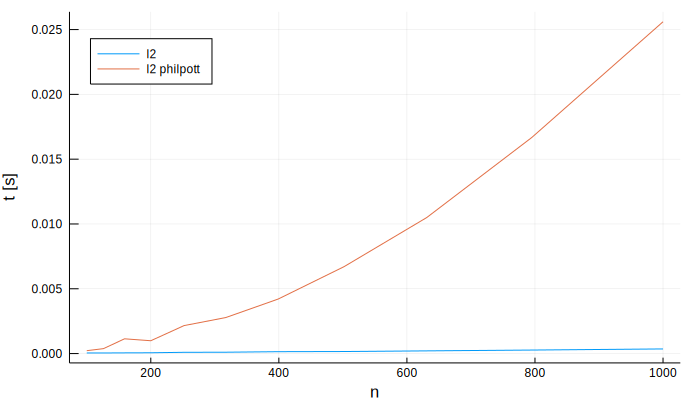

In [6]:
l = 2:0.1:3;
n = ceil.(Int64, 10 .^l);

ProjectionsExamples.philpott_timecomparison(n, maxreps = 10)

## 2. Problem (8) 

$$
\begin{aligned}
\operatorname*{minimize}_{\pmb p,\pmb q, r}\ & \frac12 \|\pmb p - \pmb p^0\|^2 + \frac12 \| \pmb q - \pmb q^0\|^2 + \frac12(r-r^0)^2 \\
\operatorname{subject\ to}\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le C_2r,\quad\forall j=1,\dots,m.
\end{aligned}
$$

### 2.1. Comparison with a solver

In [7]:
n  = 20;
m  = 30;
p0 = sort(rand(Normal(0,1), n));
q0 = sort(rand(Normal(0,1), m));
r0 = rand(Uniform(0,1))
C1 = 0.7;
C2 = 0.9;

p_solver, q_solver, r_solver = Projections.simplex_mod1_exact(p0, q0, r0, C1, C2);
p, q, r                      = Projections.simplex_mod1(p0, q0, r0, C1, C2; atol = atol);

To check if the solution `p`, `q`, `r` given by our algorithm is correct, we compare it with the solution `p_solver`, `q_solver`, `r_solver` given by the  [ECOS](https://github.com/JuliaOpt/ECOS.jl)  solver. Below we show the norm of the differences between these two solutions, their values of the objective function
$$
L(p,q,r) = \frac12 \|\pmb p - \pmb p^0\|^2 + \frac12 \| \pmb q - \pmb q^0\|^2 + \frac12(r-r^0)^2 
$$
and their values of constraints

In [8]:
ProjectionsExamples.mod1_comparison(p, p_solver, q, q_solver, r, r_solver, p0, q0, r0, C1, C2, sd)

‖p_solver - p‖ = 8.21678017777e-6
‖q_solver - q‖ = 1.76241189822e-5
‖r_solver - r‖ = 8.64859082128e-8

L(p,q,r)                      = 3.88268865578
L(p_solver,q_solver,r_solver) = 3.8826886

Solver solution: 
  ⋅ ∑p = ∑q:       6.85548459161 = 6.85548459161
  ⋅ min(p) ≧ 0:    6.06393378011e-10 ≧ 0
  ⋅ min(q) ≧ 0:    1.23162390304e-10 ≧ 0
  ⋅ max(p) ≦ C1:   0.700000000143 ≦ 0.7
  ⋅ max(q) ≦ C2*r: 1.01981918548 ≦ 1.01981918644
Our solution: 
  ⋅ ∑p = ∑q:       6.85546524858 = 6.85546524858
  ⋅ min(p) ≧ 0:    0.0 ≧ 0
  ⋅ min(q) ≧ 0:    0.0 ≧ 0
  ⋅ max(p) ≦ C1:   0.7 ≦ 0.7
  ⋅ max(q) ≦ C2*r: 1.01981926428 ≦ 1.01981926428


It is clear that our solution is almost identical to the solution given by the solver. The following figures show the comparison of the original inputs $\pmb p^{0}$, $\pmb q^{0}$, $r^{0}$ with the outputs $\pmb p$, $\pmb q$, $r$ given by the projection.  

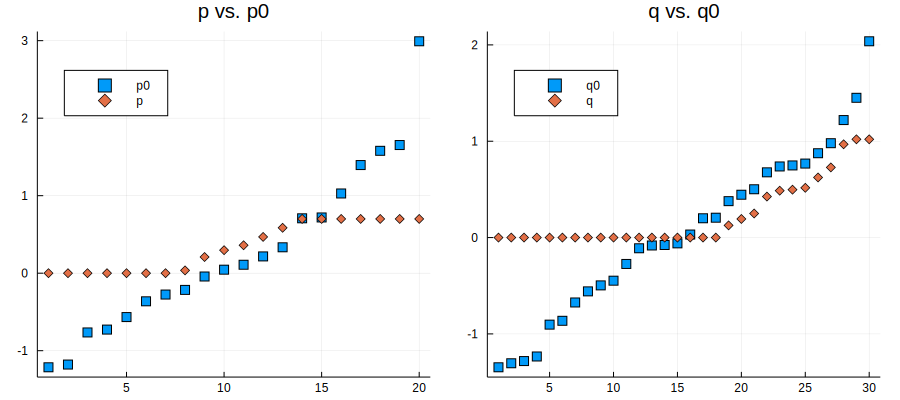

In [9]:
ProjectionsExamples.mod1_plots(p, p_solver, q, q_solver, p0, q0, n, m, sd)

### 2.2. Time comparison

As for the problem (6), in this section we provide a simple comparison of the time complexity of the presented algorithms. The following settings of inputs and parameters were used for the experiments

- $\pmb p^{0} \sim \mathit{Normal}(0,1)$,
- $\pmb q^{0} \sim \mathit{Normal}(0,1)$,
- $\pmb r^{0} \sim \mathit{Uniform}(0,1)$,
- $N \in [10^{2},10^{5}]$,
    - $n = \lceil 0.3\cdot N \rceil$
    - $m = \lceil 0.7\cdot N \rceil$
- $C1 = 0.7$
- $C2 = 0.9$

where $n$ is the length of the vector $\pmb p^{0}$ and $m$ is the length of the vector $\pmb q^{0}$. For each $N$ we ran each algorithm ten times and averaged execution times. Since our algorithm uses root finding method, we show two different methods for finding root in the time comparison: `bisection` and `secant` method (both methods are implemented in [Roots](https://github.com/JuliaMath/Roots.jl) package).

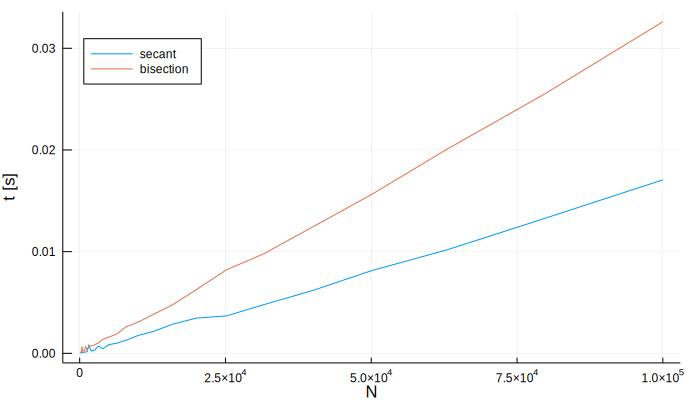

In [10]:
l = 2:0.1:5
N = @. ceil(Int64, 10^l);

ProjectionsExamples.mod1_timecomparison(N; maxreps = 10)

In the figure above we see (almost) linear dependence of time on the data size $N$. We can also see, that the algorithm using the `secant` method is faster than the one using the `bisection` method. On the other hand,  the algorithm using the `bisection` method has a guaranteed convergence.

## 3. Problem (9) 

$$
\begin{aligned}
\operatorname*{minimize}_{\pmb p,\pmb q, r}\ & \frac12 \|\pmb p - \pmb p^0\|^2 + \frac12 \| \pmb q - \pmb q^0\|^2 \\
\operatorname{subject\ to}\ &\sum_{i=1}^n p_i=\sum_{j=1}^m q_j,\\
&0\le p_i\le C_1,\quad\forall i=1,\dots,n,\\
&0\le q_j\le \frac{1}{C_2}\sum_{i=1}^n p_i,\quad\forall j=1,\dots,m.
\end{aligned}
$$

### 3.1. Comparison with a solver

In [11]:
n  = 20;
m  = 30;
p0 = sort(rand(Normal(0,1), n));
q0 = sort(rand(Normal(0,1), m));
C1 = 0.7;
C2 = 9;

p_solver, q_solver = Projections.simplex_mod2_exact(p0, q0, C1, C2);
p, q               = Projections.simplex_mod2(p0, q0, C1, C2; atol = atol);

To check if the `p`, `q` given by our algorithm is correct, we compare it with the `p_solver`, `q_solver` solution given by the  [ECOS](https://github.com/JuliaOpt/ECOS.jl)  solver. Below we show the norm of the differences between these two solutions, their values of the objective function
$$
L(p,q,r) = \frac12 \|\pmb p - \pmb p^0\|^2 + \frac12 \| \pmb q - \pmb q^0\|^2
$$
and their values of constraints
Below you can see the norm of the differences between these two solutions 

In [12]:
ProjectionsExamples.mod2_comparison(p, p_solver, q, q_solver, r, r_solver,  p0, q0, r0, C1, C2, sd)

MethodError: MethodError: no method matching mod2_comparison(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,2}, ::Float64, ::Float64, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Float64, ::Int64, ::Int64)
Closest candidates are:
  mod2_comparison(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at /home/vaclav/GoogleDrive/Projects/julia/v1.0.0/ProjectionsExamples/src/examples.jl:198

It is clear that our solution is almost identical to the solution given by the solver.

The following figures show the comparison of the original inputs $\pmb p^{0}$, $\pmb q^{0}$ with the outputs $\pmb p$, $\pmb q$ given by the projection.  

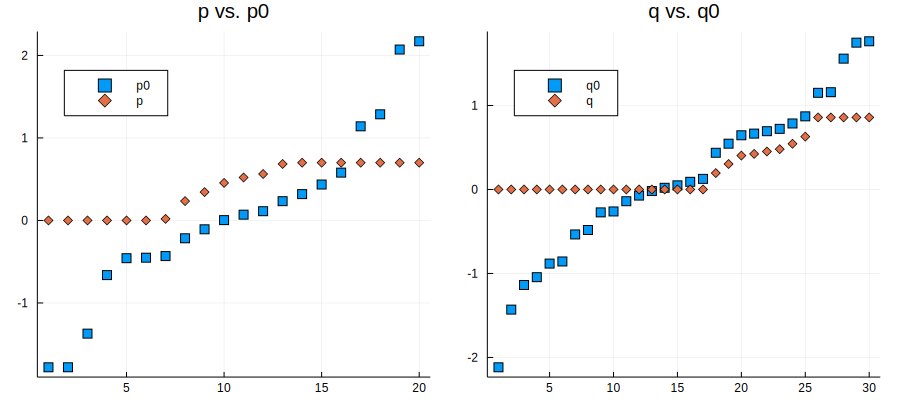

In [13]:
ProjectionsExamples.mod2_plots(p, p_solver, q, q_solver, p0, q0, n, m, sd)

### 3.2. Time comparison

As fr the previous problems, in this section we provide a simple comparison of the time complexity of the presented algorithms. The following settings of inputs and parameters were used for the experiments

- $\pmb p^{0} \sim \mathit{Normal}(0,1)$,
- $\pmb q^{0} \sim \mathit{Normal}(0,1)$,
- $N \in [10^{2},10^{5}]$,
    - $n = \lceil 0.3\cdot N \rceil$
    - $m = \lceil 0.7\cdot N \rceil$
- $C1 = 0.7$
- $C2 = \lceil \frac{m}{10} \rceil$

where $n$ is the length of the vector $\pmb p^{0}$ and $m$ is the length of the vector $\pmb q^{0}$. For each $N$ we ran each algorithm ten times and averaged execution times. Since our algorithm uses root finding method, we show two different methods for finding root in the time comparison: `bisection` and `secant` method (both methods are implemented in [Roots](https://github.com/JuliaMath/Roots.jl) package).

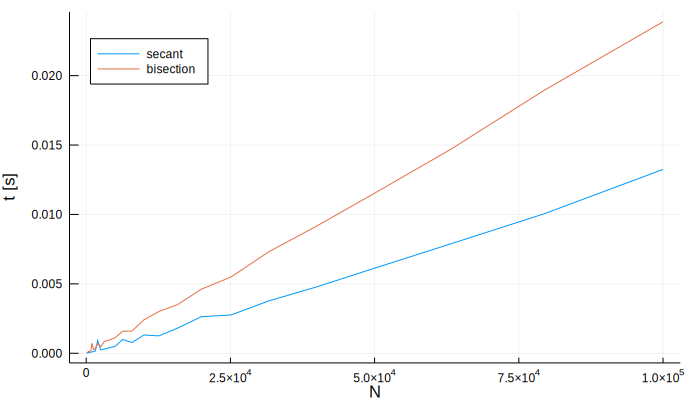

In [14]:
l = 2:0.1:5
N = @. ceil(Int64, 10^l);

ProjectionsExamples.mod2_timecomparison(N; maxreps = 10)

In the figure above we see (almost) linear dependence of time on the data size $N$. We can also see, that the algorithm using the `secant` method is faster than the one using the `bisection` method. On the other hand,  the algorithm using the `bisection` method has a guaranteed convergence.